<div class="alert alert-block alert-info">
    <h2><center>Distracted Driver Detection Using CNN</center></h2>
    <center><p>Languaje used: Python</p>
        <p>Framework used: tf.keras</p>
    </center>
</div>

## Libraries

In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model

## Preprocessing data

In [2]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

## Get Data

In [3]:
#Paths
pathTrain_Images = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/"
pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


## Check data integrity

### Classes:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

17939
(128, 128, 3)


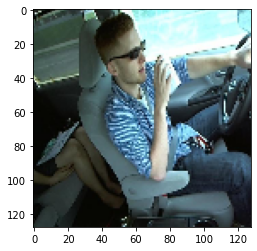

Class: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:
print(len(X_Train))
print(X_Train[202].shape)
im = X_Train[202]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[202]))

## Check data distribution

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

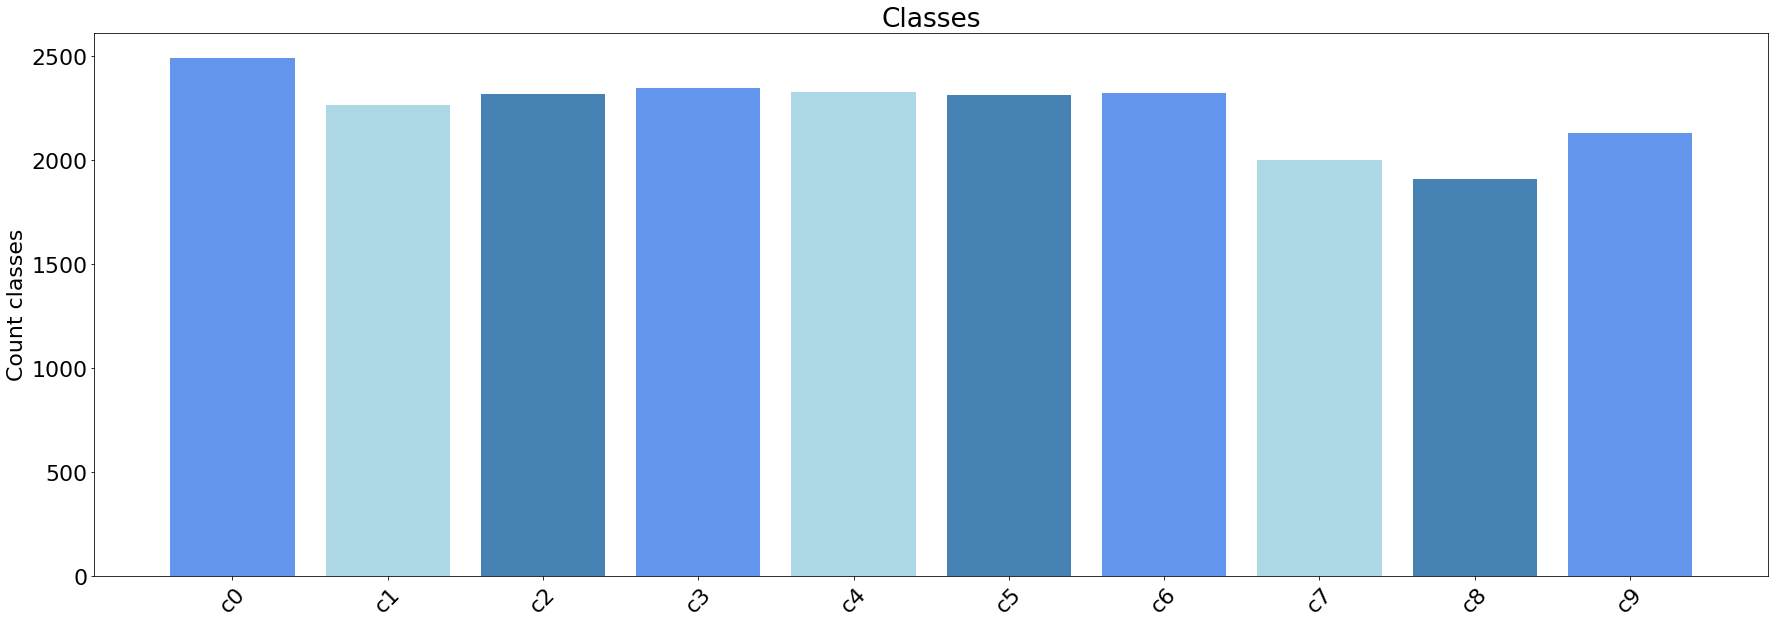

In [5]:
data_file = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

# Create architecture

In [6]:

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(
    input_shape=(128, 128, 3)
))

model.add(
    keras.layers.Conv2D(
        filters=32,
        kernel_size=(5,5),
        strides = (1,1),
        padding='same',
        activation='relu',
        name='Conv_1'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_1'))#Image_size: 32*64*64(32 filters,image_size 64*64)

model.add(
    keras.layers.Conv2D(
        filters = 64,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_2'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_2'))#Image_size: 64*32*32(64 filters,image_size 32*32)

model.add(
    keras.layers.Conv2D(
        filters = 128,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_3'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_3'))#Image_size: 128*16*16(128 filters,image_size 16*16)

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_4'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_4'))#Image_size: 256*8*8(256 filters,image_size 8*8)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu',name = 'fc_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512, activation='relu',name = 'fc_2'))
model.add(keras.layers.Dense(units=10,activation='softmax',name = 'fc_3'))
model.save('/tmp/model')
#model.compute_output_shape(input_shape=(256,8,8,1))

In [7]:
tf.random.set_seed(1)
#model.build(input_shape=(None,128,128,3))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        51264     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 32, 32, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 32, 32, 128)       204928    
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 16, 16, 128)       0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 16, 16, 256)       8

## Train model

In [8]:
history = model.fit(x = X_Train, y=Y_Train,epochs = 10, batch_size = 500, verbose = 1,validation_split=0.2)

Epoch 1/10
29/29 [==============================] - 8s 284ms/step - loss: 18.8840 - accuracy: 0.1904 - val_loss: 1.6240 - val_accuracy: 0.4105
Epoch 2/10
29/29 [==============================] - 7s 227ms/step - loss: 1.2246 - accuracy: 0.5661 - val_loss: 0.7216 - val_accuracy: 0.7603
Epoch 3/10
29/29 [==============================] - 7s 231ms/step - loss: 0.4906 - accuracy: 0.8515 - val_loss: 0.3050 - val_accuracy: 0.9114
Epoch 4/10
29/29 [==============================] - 7s 229ms/step - loss: 0.2455 - accuracy: 0.9256 - val_loss: 0.1511 - val_accuracy: 0.9613
Epoch 5/10
29/29 [==============================] - 7s 228ms/step - loss: 0.1300 - accuracy: 0.9627 - val_loss: 0.0978 - val_accuracy: 0.9738
Epoch 6/10
29/29 [==============================] - 7s 226ms/step - loss: 0.0836 - accuracy: 0.9735 - val_loss: 0.0937 - val_accuracy: 0.9727
Epoch 7/10
29/29 [==============================] - 7s 228ms/step - loss: 0.0691 - accuracy: 0.9789 - val_loss: 0.0697 - val_accuracy: 0.9813
Epoch

## Evaluate model with test data

In [9]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 1s 9ms/step - loss: 0.0834 - accuracy: 0.9775


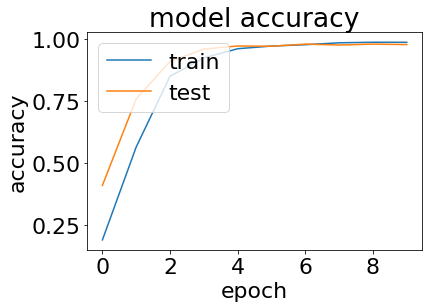

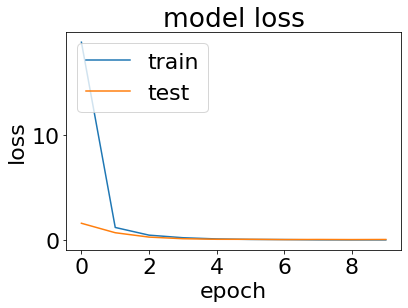

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

### Save weights

In [11]:
model_json = model.to_json()
model.save_weights('Train_weights_1.h5',overwrite = True)

In [12]:
model.load_weights('Train_weights_1.h5')

## Show architecture distribution

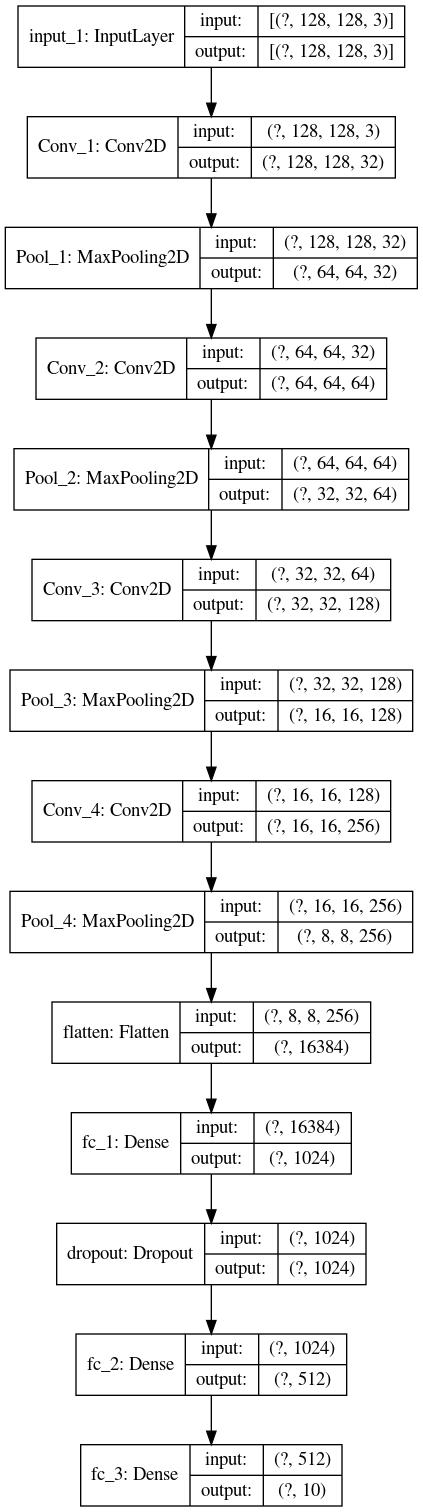

In [13]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

## Predict Test data and create a submission file

In [14]:
df = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})
def _submission(pathPropagate_Images,df):
    for imgs in glob.glob(os.path.join(pathPropagate_Images,'*.jpg')):
        img_cv = cv2.imread(imgs)
        img_cv_r = cv2.resize(img_cv,(128,128))
        img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
        arr_predict = model.predict(img_cv_predict,batch_size = 1)
        #print(imgs.split('/')[-1])
        df = df.append(
            {
                'img':imgs.split('/')[-1],
                'c0':round(arr_predict[0][0],2), 
                'c1':round(arr_predict[0][1],2),
                'c2':round(arr_predict[0][2],2),
                'c3':round(arr_predict[0][3],2),
                'c4':round(arr_predict[0][4],2),
                'c5':round(arr_predict[0][5],2),
                'c6':round(arr_predict[0][6],2),
                'c7':round(arr_predict[0][7],2),
                'c8':round(arr_predict[0][8],2),
                'c9':round(arr_predict[0][9],2)
            },
            ignore_index=True
        )
    return df

In [15]:
img_cv = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_41.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))

[[9.7142237e-01 3.0797627e-04 1.4692083e-05 1.3618111e-03 1.2506326e-04
  1.1511972e-03 3.0145922e-04 5.1445264e-04 9.9985087e-03 1.4802444e-02]]
0.01


In [16]:
pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"
df = _submission(pathPropagate_Images,df)

In [17]:
print(df.shape)
df.head(50)

(79726, 11)


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_5418.jpg,0.00,0.03,0.00,0.00,0.01,0.00,0.09,0.56,0.30,0.02
1,img_73820.jpg,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,img_53451.jpg,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,img_101005.jpg,0.00,0.39,0.00,0.00,0.00,0.00,0.05,0.00,0.55,0.00
4,img_1506.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
5,img_54537.jpg,0.11,0.05,0.00,0.14,0.55,0.00,0.05,0.00,0.02,0.09
6,img_57568.jpg,0.01,0.00,0.00,0.02,0.97,0.00,0.00,0.00,0.00,0.00
7,img_15527.jpg,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,img_13106.jpg,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00
9,img_12671.jpg,0.00,0.01,0.00,0.01,0.05,0.08,0.00,0.02,0.18,0.65


## Save submission file

In [18]:
df.to_csv('submission_file.csv',index = False)